# Integral Equation Model Comparisons
Purpose of this notebook is to EOS calculations for comparisons to George Petrov's Average Atom model, and Morales EOS Hydrogen paper

[https://journals.aps.org/pre/abstract/10.1103/PhysRevE.81.021202](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.81.021202)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

from hnc.hnc.PIE import Plasma_of_Ions_and_Electrons as PLASMA

from hnc.hnc.constants import *
from hnc.hnc.misc import n_from_rs, rs_from_n

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
                
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

</style>
""")


ModuleNotFoundError: No module named 'mendeleev'


#### Load George Data

In [2]:
GP_H_file = "H-rho=1.dat"
GP_df = read_csv(GP_H_file, delim_whitespace=True, header=0)
GP_PMbar_1 = GP_df['P_ishikawa'][3:]
GP_PMbar_2 = GP_df['P_fauss'][3:]
GP_Te_eV = GP_df['Te'][3:]

In [3]:
GP_df

,Te,eta,Ne_b,Ne_quasi,Ne_sc,Z,mu,nu_mom,nu_tot,sigma,k_th,L,U,G,P_ishikawa,P_fauss
0,0.1,1.0,0.0,0.0,1.0,1.0,0.60830,0.112600,0.44460,0.3495,0.004226,3.290,0.027324,1.235000e-05,0.6827,2.898
1,0.2,1.0,0.0,0.0,1.0,1.0,0.60960,0.111800,0.44000,0.3526,0.008530,3.291,0.027421,1.231000e-05,0.7285,2.935
2,0.5,1.0,0.0,0.0,1.0,1.0,0.61320,0.109700,0.42720,0.3618,0.021930,3.298,0.027736,1.221000e-05,0.8676,3.051
3,1.0,1.0,0.0,0.0,1.0,1.0,0.61840,0.106800,0.40890,0.3765,0.045970,3.323,0.028337,1.207000e-05,1.1070,3.249
4,2.0,1.0,0.0,0.0,1.0,1.0,0.62610,0.102800,0.38020,0.4044,0.101200,3.404,0.029878,1.190000e-05,1.6300,3.687
5,5.0,1.0,0.0,0.0,1.0,1.0,0.62760,0.099500,0.32790,0.4783,0.311000,3.539,0.037150,1.198000e-05,3.6120,5.376
6,10.0,1.0,0.0,0.0,1.0,1.0,0.54060,0.101800,0.28640,0.5767,0.821000,3.874,0.053984,1.215000e-05,7.5520,8.886
7,20.0,1.0,0.0,0.0,1.0,1.0,0.09214,0.103100,0.24640,0.8232,2.499000,4.130,0.094795,1.116000e-05,16.1800,16.890
8,50.0,1.0,0.0,0.0,1.0,1.0,-2.42900,0.088140,0.19200,1.9690,13.760000,3.803,0.232150,7.608000e-06,43.2700,43.670
9,100.0,1.0,0.0,0.0,1.0,1.0,-8.66900,0.063270,0.14550,4.4600,61.560000,3.756,0.471360,4.457000e-06,89.7400,89.970


#### Load Morales Data

In [4]:
Morales_file = "Morales_EOS_data.dat"
Morales_df = read_csv(Morales_file, delim_whitespace=True, header=4)
Morales_EAU  = Morales_df['E[AU]']
Morales_PGPa = Morales_df['P[GPa]']
Morales_TK   = Morales_df['T[K]']
Morales_PMbar =  1e-2*Morales_PGPa
Morales_TeV = Morales_TK/eV_to_K

In [5]:
Morales_df

,T[K],ρgpercc,rs,E[AU],P[GPa]
0,2000,0.983,1.4,-0.5117,213
1,3000,0.983,1.4,-0.5057,220
2,4000,0.983,1.4,-0.4993,232
3,6000,0.983,1.4,-0.4869,256
4,8000,0.983,1.4,-0.4767,275
5,10000,0.983,1.4,-0.4674,295


#### Load atoMEC data

In [6]:
atoMEC_file = "atoMEC_H_pressures.dat"
atoMEC_df = read_csv(atoMEC_file, delim_whitespace=True, header=0)
atoMEC_TeV = atoMEC_df['T[eV]']
atoMEC_PAU = atoMEC_df['P[AU]']
atoMEC_PMbar = atoMEC_PAU*AU_to_bar/1e6
atoMEC_df

,T[eV],P[AU]
0,0.172347,0.004035
1,0.258520,0.004043
2,0.344693,0.004054
3,0.517040,0.004084
4,0.689386,0.004127
5,0.861733,0.004182
6,1.000000,0.004235
7,2.000000,0.004849
8,5.000000,0.008853
9,10.000000,0.019958


### Set Parameters in Paper and Plot

In [7]:
name = 'Hydrogen'
Z, A = 1,1 

Te_eV_list = np.geomspace(np.min(Morales_TeV), np.max(GP_Te_eV), num=15) #np.array(GP_Te_eV) # eV
Ti_eV_list = Te_eV_list
ni_cc = 5.98e23
ni_AU = ni_cc/cm_to_AU**3

ri_cm = rs_from_n(ni_cc)  # cm
ri_AU = ri_cm*cm_to_AU    # AU 

In [8]:
ri_AU

1.3914542638521432

#### Run Ornstein-Zernike Closure

In [9]:
# def plasma_output(plasma):
#     plasma.run_hnc()
#     try: 
#         plasma.hnc.βu_r_matrix[1,1] -= plasma.βP_ee
#     except:
#         plasma.hnc.βu_r_matrix[1,1] -= plasma.qsp.βv_Pauli(plasma.hnc.r_array, plasma.qsp.Λee)
#     Pe_hnc_id, Pe_hnc_ex   = plasma.hnc.rho[1]*plasma.hnc.Temp_list[1],  np.sum( plasma.hnc.excess_pressure_matrix(),axis=1 )[1] 
#     try: 
#         plasma.hnc.βu_r_matrix[1,1] += plasma.βP_ee
#     except:
#         plasma.hnc.βu_r_matrix[1,1] += plasma.qsp.βv_Pauli(plasma.hnc.r_array, plasma.qsp.Λee)
    
#     Pe_Mbar_id, Pe_Mbar_ex = P_hnc_to_Mbar(Pe_hnc_id), P_hnc_to_Mbar(Pe_hnc_ex)
#     Pe_Mbar = Pe_Mbar_id + Pe_Mbar_ex
#     return Pe_Mbar_id, Pe_Mbar_ex, Pe_Mbar

def plasma_output(plasma):
    plasma.run_hnc()
    try: 
        plasma.hnc.βu_r_matrix[1,1] -= plasma.βP_ee
    except:
        plasma.hnc.βu_r_matrix[1,1] -= plasma.qsp.βv_Pauli(plasma.hnc.r_array, plasma.qsp.Λee)
    # Make pressures
    Pe_hnc_id, Pe_hnc_ex   = plasma.hnc.rho[1]*plasma.hnc.Temp_list[1],  np.sum( plasma.hnc.excess_pressure_matrix(),axis=1 )[1] 
    Pi_hnc_id, Pi_hnc_ex   = plasma.hnc.rho[0]*plasma.hnc.Temp_list[0],  np.sum( plasma.hnc.excess_pressure_matrix(),axis=1 )[0] 
    try: 
        plasma.hnc.βu_r_matrix[1,1] += plasma.βP_ee
    except:
        plasma.hnc.βu_r_matrix[1,1] += plasma.qsp.βv_Pauli(plasma.hnc.r_array, plasma.qsp.Λee)
    
    Pe_Mbar = P_hnc_to_Mbar(Pe_hnc_id + Pe_hnc_ex) 
    Pi_Mbar = P_hnc_to_Mbar(Pi_hnc_id + Pi_hnc_ex) 
    
    return Pe_Mbar, Pi_Mbar, Pe_Mbar + Pi_Mbar 


name1 = 'OZ - g'
plasma1 = lambda T_eV: PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Z,
                 βu_options = {'add_bridge':False,'bridge':'ocp', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0,'which_Tij':'geometric'},
                 hnc_options= {'kappa_multiscale':10, 'R_max':20,'N_bins':1000, 
                               'h_max':2e2,'oz_method':'standard'},
                 hnc_solve_options={'alpha_Picard':0.5, 'num_iterations':1e4})
name2 = 'OZ - th'
plasma2 = lambda T_eV: PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Z,
                 βu_options = {'add_bridge':False,'bridge':'ocp', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0,'which_Tij':'thermal'},
                 hnc_options= {'kappa_multiscale':10, 'R_max':20,'N_bins':1000, 
                               'h_max':2e2,'oz_method':'standard'},
                 hnc_solve_options={'alpha_Picard':0.5, 'num_iterations':1e4})
name3 = 'OZ - th  Pauli'
plasma3 = lambda T_eV: PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Z, find_βuee=True,
                 βu_options = {'add_bridge':False,'bridge':'ocp', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0,'which_Tij':'thermal'},
                 hnc_options= {'kappa_multiscale':10, 'R_max':20,'N_bins':1000, 
                               'h_max':2e2,'oz_method':'standard'},
                 hnc_solve_options={'alpha_Picard':0.5, 'num_iterations':1e4})
name4 = 'SVT - th'
plasma4 =  lambda T_eV: PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Z,
                 βu_options = {'add_bridge':False,'bridge':'ocp', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0},
                 hnc_options= {'kappa_multiscale':10, 'R_max':20,'N_bins':1000, 
                               'h_max':2e2,'oz_method':'svt'},
                 hnc_solve_options={'alpha_Picard':0.5,'num_iterations':1e4})

P_hnc_to_AU   = lambda P_hnc: (P_hnc/ri_AU**3) 
P_hnc_to_bar  = lambda P_hnc: P_hnc_to_AU(P_hnc) *  AU_to_bar 
P_hnc_to_Mbar = lambda P_hnc: 1e-6*P_hnc_to_bar(P_hnc)
P_hnc_to_GPa  = lambda P_hnc: P_hnc_to_bar(P_hnc) * 1e5 / 1e9 

### Compute all plasma models for list of densities

In [10]:
P_list_1 = []
P_list_2 = []
P_list_3 = []
P_list_4 = []

for T_eV in Te_eV_list:
    """
    """
    #1
    plasma = plasma1(T_eV)
    Pe, Pi, P = plasma_output(plasma)
    P_list_1.append( [Pe, Pi, P] )
    #2
    plasma = plasma2(T_eV)
    Pe, Pi, P = plasma_output(plasma)
    P_list_2.append( [Pe, Pi, P] )
    #3
    plasma = plasma3(T_eV)
    Pe, Pi, P = plasma_output(plasma)
    P_list_3.append( [Pe, Pi, P] )
    # #4
    plasma = plasma4(T_eV)
    Pe, Pi, P = plasma_output(plasma)
    P_list_4.append( [Pe, Pi, P] )
    

Te_in_eV: 0.172
Ti_in_eV: 0.172
0: Initial condition Total Error: 1.125e+01
Exiting status 0, reverting to best index so far: 806
Final iter:807, Total Error: 9.788e-09
Te_in_eV: 0.172
Ti_in_eV: 0.172
0: Initial condition Total Error: 1.064e+01
Exiting status 0, reverting to best index so far: 802
Final iter:803, Total Error: 9.861e-09
Te_in_eV: 0.172
Ti_in_eV: 0.172


/home/zach/plasma/hnc/hnc/PIE.py:186: RuntimeWarning: overflow encountered in exp
  integrand = lambda t: t*np.sin(sin_arg*t)/(1+np.exp(t**2-η))
/home/zach/plasma/hnc/hnc/PIE.py:193: RuntimeWarning: overflow encountered in exp
  f_of_k = 1/(  1+np.exp((dense_hnc.k_array/self.qsp.ri)**2/(2*m_e*self.qsp.Te) - η) )


0: Initial condition Total Error: 1.064e+01
Exiting status 0, reverting to best index so far: 802
Final iter:803, Total Error: 9.839e-09
Te_in_eV: 0.172
Ti_in_eV: 0.172
0: Initial condition Total Error: 1.064e+01


/home/zach/plasma/hnc/hnc/hnc.py:330: RuntimeWarning: overflow encountered in exp
  h_r_matrix = -1 + np.exp(γs_r_matrix - self.βu_s_r_matrix) # 2. γ_r,u_s_r  -> h_r   (HNC)
/home/zach/plasma/hnc/hnc/hnc.py:432: RuntimeWarning: overflow encountered in exp
  tot_eqn =  1 + h_r_matrix  - np.exp(-self.βu_s_r_matrix + h_r_matrix - c_s_r_matrix )


QUIT: Total error infinite.
Exiting status 1, reverting to best index so far: 132
Final iter:162, Total Error: 2.844e-03

Root Finder:  True The solution converged. final err: 1.861e-11
Te_in_eV: 0.336
Ti_in_eV: 0.336
0: Initial condition Total Error: 6.813e+00
Exiting status 0, reverting to best index so far: 452
Final iter:453, Total Error: 9.880e-09
Te_in_eV: 0.336
Ti_in_eV: 0.336
0: Initial condition Total Error: 6.743e+00
Exiting status 0, reverting to best index so far: 449
Final iter:450, Total Error: 9.839e-09
Te_in_eV: 0.336
Ti_in_eV: 0.336
0: Initial condition Total Error: 6.743e+00
Exiting status 0, reverting to best index so far: 449
Final iter:450, Total Error: 9.822e-09
Te_in_eV: 0.336
Ti_in_eV: 0.336
0: Initial condition Total Error: 6.739e+00
QUIT: Total error infinite.
Exiting status 1, reverting to best index so far: 56
Final iter:66, Total Error: 1.641e-02

Root Finder:  True The solution converged. final err: 6.236e-12
Te_in_eV: 0.656
Ti_in_eV: 0.656
0: Initial cond

/home/zach/plasma/hnc/hnc/hnc.py:507: RuntimeWarning: overflow encountered in exp
  h_r_matrix = -1 + np.exp(γs_r_matrix - self.βu_s_r_matrix) # 2. γ_r,u_s_r  -> h_r   (HNC)
/home/zach/plasma/hnc/hnc/hnc.py:623: RuntimeWarning: overflow encountered in exp
  hnc_err = np.linalg.norm(- 1 - self.h_r_matrix   + np.exp( -self.βu_r_matrix + self.h_r_matrix - self.c_r_matrix ))/np.sqrt(self.N_bins*self.N_species**2)
/home/zach/plasma/hnc/hnc/hnc.py:631: RuntimeWarning: invalid value encountered in subtract
  Δ_err = np.array(self.tot_err_list[-iters_to_check:-2]) - np.array(self.tot_err_list[-iters_to_check + 1:-1])


QUIT: Total error infinite.
Exiting status 1, reverting to best index so far: 11
Final iter:21, Total Error: 2.912e-01

Root Finder:  False The number of calls to function has reached maxfev = 10000. final err: 1.209e-01
Te_in_eV: 0.656
Ti_in_eV: 0.656
0: Initial condition Total Error: 4.187e+00
Exiting status 0, reverting to best index so far: 259
Final iter:260, Total Error: 9.398e-09
Te_in_eV: 0.656
Ti_in_eV: 0.656
0: Initial condition Total Error: 4.188e+00
Exiting status 0, reverting to best index so far: 259
Final iter:260, Total Error: 9.418e-09
Te_in_eV: 0.656
Ti_in_eV: 0.656
0: Initial condition Total Error: 4.183e+00
QUIT: Total error infinite.
Exiting status 1, reverting to best index so far: 24
Final iter:33, Total Error: 2.956e-02

Root Finder:  False The number of calls to function has reached maxfev = 10000. final err: 1.433e-02
Te_in_eV: 1.281
Ti_in_eV: 1.281
0: Initial condition Total Error: 2.560e+00
Exiting status 0, reverting to best index so far: 101
Final iter:102

/home/zach/plasma/hnc/hnc/PIE.py:187: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  κ = 3*(2*self.qsp.Te*m_e) / (self.qsp.k_F**3 * r) *quad(integrand, 0, t_max)[0]


0: Initial condition Total Error: 1.878e-01
Exiting status 0, reverting to best index so far: 24
Final iter:25, Total Error: 7.350e-09
Te_in_eV: 36.228
Ti_in_eV: 36.228
0: Initial condition Total Error: 1.894e-01
Exiting status 0, reverting to best index so far: 24
Final iter:25, Total Error: 6.664e-09
Te_in_eV: 70.693
Ti_in_eV: 70.693
0: Initial condition Total Error: 1.096e-01
Exiting status 0, reverting to best index so far: 23
Final iter:24, Total Error: 8.745e-09
Te_in_eV: 70.693
Ti_in_eV: 70.693
0: Initial condition Total Error: 1.082e-01
Exiting status 0, reverting to best index so far: 23
Final iter:24, Total Error: 8.932e-09
Te_in_eV: 70.693
Ti_in_eV: 70.693


/home/zach/plasma/hnc/hnc/PIE.py:187: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  κ = 3*(2*self.qsp.Te*m_e) / (self.qsp.k_F**3 * r) *quad(integrand, 0, t_max)[0]


0: Initial condition Total Error: 1.079e-01
Exiting status 0, reverting to best index so far: 23
Final iter:24, Total Error: 9.263e-09
Te_in_eV: 70.693
Ti_in_eV: 70.693
0: Initial condition Total Error: 1.083e-01
Exiting status 0, reverting to best index so far: 23
Final iter:24, Total Error: 8.767e-09
Te_in_eV: 137.946
Ti_in_eV: 137.946
0: Initial condition Total Error: 6.043e-02
Exiting status 0, reverting to best index so far: 23
Final iter:24, Total Error: 6.209e-09
Te_in_eV: 137.946
Ti_in_eV: 137.946
0: Initial condition Total Error: 6.014e-02
Exiting status 0, reverting to best index so far: 23
Final iter:24, Total Error: 6.193e-09
Te_in_eV: 137.946
Ti_in_eV: 137.946
0: Initial condition Total Error: 6.009e-02
Exiting status 0, reverting to best index so far: 23
Final iter:24, Total Error: 6.245e-09
Te_in_eV: 137.946
Ti_in_eV: 137.946
0: Initial condition Total Error: 6.015e-02
Exiting status 0, reverting to best index so far: 23
Final iter:24, Total Error: 6.191e-09
Te_in_eV: 26

Now Plot 

In [11]:
P_list_1 = np.array(P_list_1)
P_list_2 = np.array(P_list_2)
P_list_3 = np.array(P_list_3)
P_list_4 = np.array(P_list_4)

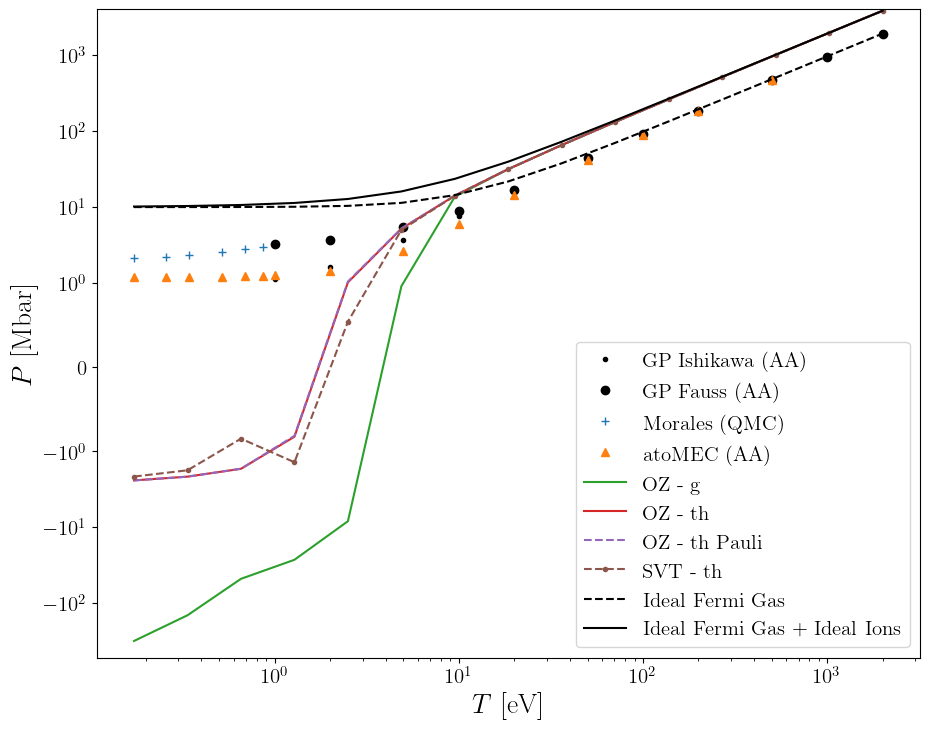

In [12]:
from hnc.hnc.misc import P_Ideal_Fermi_Gas

fig, axs = plt.subplots( figsize=(10,8))
axs = np.array([axs])
# fig.suptitle(r"$T_i $ eV", fontsize=25, y=0.9)

#Plot GP data 
axs[0].plot(GP_Te_eV, GP_PMbar_1, 'k.', label='GP Ishikawa (AA)')
axs[0].plot(GP_Te_eV, GP_PMbar_2, 'ko', label='GP Fauss (AA)')

#Plot Morales data
axs[0].plot(Morales_TeV, Morales_PMbar, '+', label='Morales (QMC)')

#Plot atoMEC data
axs[0].plot(atoMEC_TeV, atoMEC_PMbar, '^', label='atoMEC (AA)')

# Plot Pressure ratio
p_type=2
axs[0].plot(Te_eV_list, P_list_1[:,p_type], label=name1)
axs[0].plot(Te_eV_list, P_list_2[:,p_type], label=name2)
axs[0].plot(Te_eV_list, P_list_3[:,p_type],'--', label=name3)
# axs[0].plot(Te_eV_list, P_list_3[:,0],'--', label="CMHNC - e")
# axs[0].plot(Te_eV_list, P_list_3[:,1],'--', label="CMHNC - i")
# axs[0].plot(Te_eV_list, P_list_3[:,2],'--', label="CMHNC - e+i")
axs[0].plot(Te_eV_list, P_list_4[:,p_type],'--.', label=name4)

# Plot Fermi Pressure
Pe_ideal_Mbar = [P_Ideal_Fermi_Gas(Te_eV*eV_to_AU, ni_AU)*AU_to_bar/1e6 for Te_eV in Te_eV_list]
Pi_ideal_Mbar = Ti_eV_list*eV_to_AU*ni_AU*AU_to_bar/1e6

axs[0].plot(Te_eV_list, Pe_ideal_Mbar,'k--', label="Ideal Fermi Gas"  ) 
axs[0].plot(Te_eV_list, Pe_ideal_Mbar + Pi_ideal_Mbar,'k-', label="Ideal Fermi Gas + Ideal Ions"  ) 

for ax in axs:
    ax.legend(fontsize=15, loc='lower right')
    ax.set_xscale('log')
    ax.set_yscale('symlog', linthresh=1)
    # ax.set_yscale('log')
    # ax.set_ylim(0, 20)
    ax.set_ylabel(r"$P$ [Mbar]", fontsize=20)
    ax.set_xlabel(r"$T$ [eV]", fontsize=20)
    ax.tick_params(labelsize=15)
plt.tight_layout()

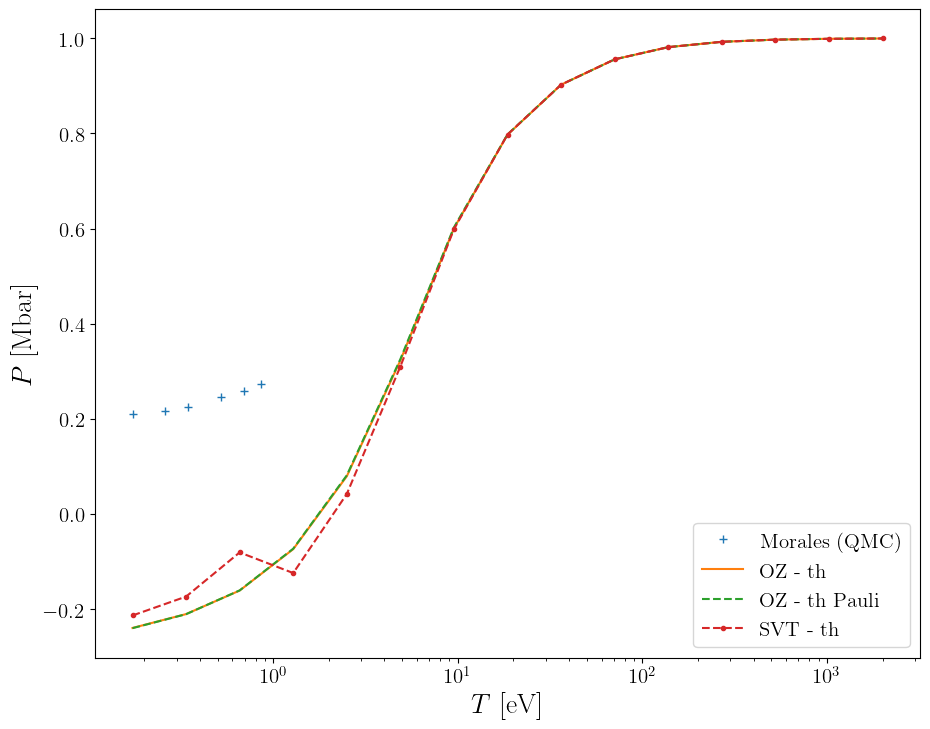

In [13]:
fig, axs = plt.subplots( figsize=(10,8))
axs = np.array([axs])
# fig.suptitle(r"$T_i $ eV", fontsize=25, y=0.9)

# Plot Fermi Pressure
P_ideal_Mbar_func = lambda Te_eV, Ti_eV: P_Ideal_Fermi_Gas(Te_eV*eV_to_AU, ni_AU)*AU_to_bar/1e6 + Ti_eV*eV_to_AU*ni_AU*AU_to_bar/1e6

#Plot Morales data
axs[0].plot(Morales_TeV, Morales_PMbar/[P_ideal_Mbar_func(T_eV, T_eV) for T_eV in Morales_TeV], '+', label='Morales (QMC)')

# Plot Pressure ratio
# axs[0].plot(Te_eV_list, P_list_1[:,2]/(Pe_ideal_Mbar + Pi_ideal_Mbar), label=name1)
axs[0].plot(Te_eV_list, P_list_2[:,2]/(Pe_ideal_Mbar + Pi_ideal_Mbar), label=name2)
axs[0].plot(Te_eV_list, P_list_3[:,2]/(Pe_ideal_Mbar + Pi_ideal_Mbar),'--', label=name3)
axs[0].plot(Te_eV_list, P_list_4[:,2]/(Pe_ideal_Mbar + Pi_ideal_Mbar),'--.', label=name4)


for ax in axs:
    ax.legend(fontsize=15, loc='lower right')
    ax.set_xscale('log')
    # ax.set_yscale('symlog', linthresh=1)
    # ax.set_yscale('log')
    # ax.set_ylim(0, 20)
    ax.set_ylabel(r"$P$ [Mbar]", fontsize=20)
    ax.set_xlabel(r"$T$ [eV]", fontsize=20)
    ax.tick_params(labelsize=15)
plt.tight_layout()